# Part A: Introduction to OpenCV and Template Matching

In the first part we will start by familiarizing with the OpenCV matctTemplate tools. 
1. We will start by operating only on the left frame of the stereo image pair. Our goal is to select a template, that is a small crop of the image, and by using the cv2.matchTemplate tool, to locate this crop on the original image. By visualizing the distance heat-map and a rectangle over the prediction we can evaluate the results of the algorithm. 
2. We will repeat the same process of the right frame of the stereo pair. 
3. Is there a way to eliminate the range of rows that we should parse to find a match? We know that both cameras are on the came level. 
4. Are there any other ways to narrow down the search area. 
5. Calculate the disparity value between the 2 frams for the template patch. 

To define the template patch we need the starting row and column as well as the block size. We consider the template to be square. 

In [1]:
# Import Section
import cv2 
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import utility as U
import numpy as np
from tqdm import tqdm
from math import tan

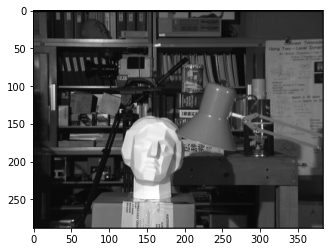

Image Shape:  (288, 384)
Template Shape:  (50, 50)


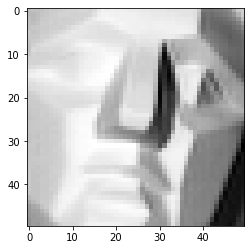

In [2]:
img = cv2.imread("sample_data/left.ppm", cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap='gray')
plt.show()
print("Image Shape: ", img.shape)

template_row_start = 165
template_col_start = 135
block_size = 50

# TODO
template = # TODO
print("Template Shape: ", template.shape)
plt.imshow(template, cmap='gray')
plt.show()

Use the template matching to locate the template in the image. We need to define a distance function that will do this. In this example we will use the square distance. You could experiment with different distance functions.  

The result of the matchTemplate should be a headmap of the distance for each patch in the image. We define a patch by the top-left point. Notice that the shape of the heat_map is smaller that the original image.

To find the patch we need to locate the point with the smallest distance. To do so we can use the cv2.minMacLoc method. 

For this cell we will use a custom function to visualize the rectangle. Notice the order of the arguments when we call the Rectangle constructor. In later cells we will the *disp_image_and_rectangle* from the utility.py. 
Just use *U.disp_image_and_rectangle(img, rect_start, template_rows, template_cols)*

Heat-map shape:  (239, 335)


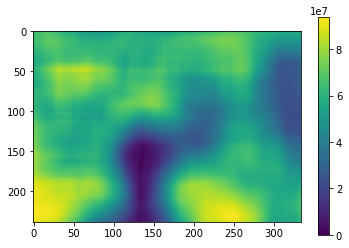

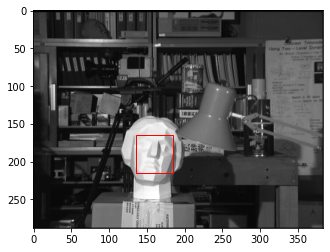

In [3]:
res = # TODO
print("Heat-map shape: ", res.shape)
plt.imshow(res)
plt.colorbar()
plt.show()

# find the location of the min value
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)


## Visualize the rectangle ##
# Get the shape of the template
rows, cols = template.shape

# Display the original image
plt.imshow(img, cmap='gray')

# Get the current reference
ax = plt.gca()

# Create a Rectangle patch
rect = Rectangle(min_loc, cols, rows, linewidth=1, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()


## Now try to locate the template in the right frame

By using the *visualize_stereo_frames* from utility.py we can visualize the two frames next to each other. 

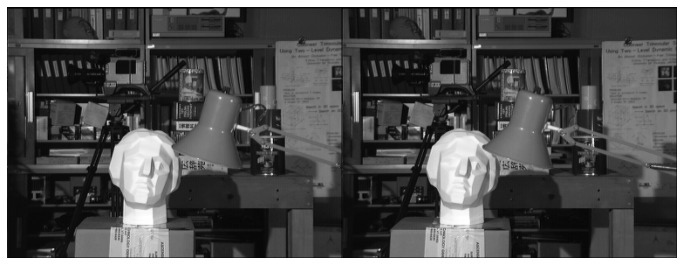

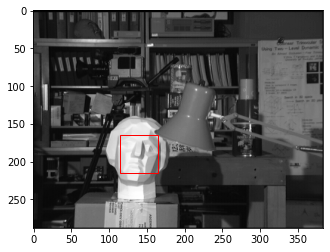

In [4]:
# Load the image
right_img = cv2.imread("sample_data/right.ppm", cv2.IMREAD_GRAYSCALE)
U.visualize_stereo_frames(img, right_img)

# Do the template matching
res = cv2.matchTemplate(right_img, template, cv2.TM_SQDIFF)

# Get the minimum distance position
_, _, min_loc_right, _ = cv2.minMaxLoc(res)

# Visualize the rectangle
U.disp_image_and_rectangle(right_img, min_loc_right, rows, cols)

### Print the row that the template was found on, in the right frame. What do you observe?


In [5]:
print("Row of the template in the left image : ", template_row_start)
print("Row of the template in the right image : ", min_loc_right[1])

Row of the template in the left image :  165
Row of the template in the right image :  165


### Narrow down the Region of Interest (RoI)


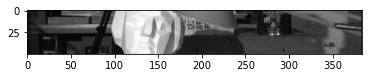

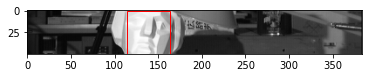

In [6]:
# TASK 1.3: Search for the template only in the same row of the second image,
#           since the cameras are on the same level 
# a. Crop the second image and only keep the row that contains the 
right_img_crop = # TODO
plt.imshow(right_img_crop, cmap="gray")
plt.show()

# Do the template matching
res = cv2.matchTemplate(right_img_crop, template, cv2.TM_SQDIFF)
# Get the minimum distance position
_, _, min_loc_right_crop, _ = cv2.minMaxLoc(res)
# Visualize the rectangle
U.disp_image_and_rectangle(right_img_crop, min_loc_right_crop, rows, cols)

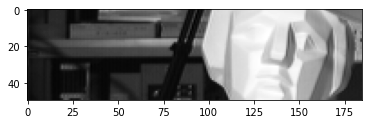

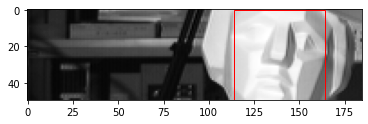

In [7]:
# TASK 1.4: Narrow the search even more
# Since we use the right frame, the template with be to the left, 
# comparing to the original position in the left image.

# Make a new crop of the image (should contain the coordinates of the template)
right_img_crop_crop = # TODO
plt.imshow(right_img_crop_crop, cmap='gray')
plt.show()

# Do the template matching
res = cv2.matchTemplate(right_img_crop_crop, template, cv2.TM_SQDIFF)
# Get the minimum distance position
_, _, min_loc_right_crop_crop, _ = cv2.minMaxLoc(res)
# Visualize the rectangle
U.disp_image_and_rectangle(right_img_crop_crop, min_loc_right_crop_crop, rows, cols)

## Disparity Calculation

In [8]:
disparity = template_col_start - min_loc_right_crop_crop[0]
print(f"The disparity value is {disparity}") 

The disparity value is 21


# Part B: Disparity extraction from stereo images

In order to calculate the disparity we need to repeat the same process that we followed for the template but for each pixel of the left image, except for the marginal pixels (right and bottom rows) that their template would be out the image frame. 

In order to start clean in the next cell we reload and visualize the stereo image frames. 

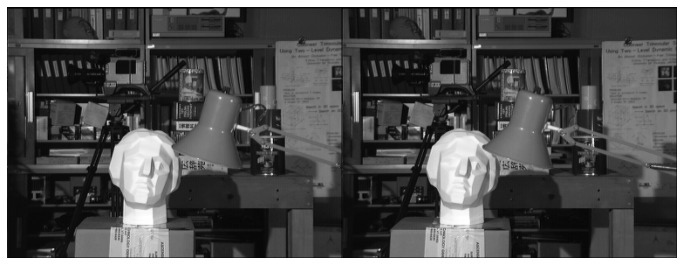

In [9]:
# Setting paths
datapath = "./sample_data/"
left_frame_path = datapath + "left.ppm"
right_frame_path = datapath + "right.ppm"
disparity_path = datapath + "truedisp.pgm"


# Loading the two frames again (both greyscale -> disparity and color version -> visualization)
left_frame = cv2.imread(left_frame_path, cv2.IMREAD_GRAYSCALE)
left_frame_color = cv2.imread(left_frame_path)
right_frame = cv2.imread(right_frame_path, cv2.IMREAD_GRAYSCALE)
right_frame_color = cv2.imread(right_frame_path)

U.visualize_stereo_frames(left_frame, right_frame)

## Disparity_map

*NOTE: Only search the left most pixels that the current pixel to find the disparity.* 

100%|████████████████████████████████████████| 280/280 [00:02<00:00, 116.07it/s]


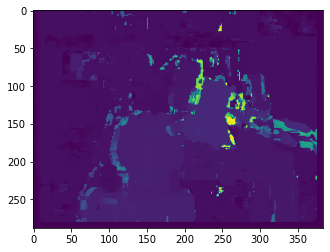

In [10]:
# setting the block size
block_size = 8


frame_shape = left_frame.shape # [288, 384]

# Create an image to store the disparity
disparity_map = np.zeros_like(left_frame)


# Parse the pixels - Use tqdm to monitor the process. 
for i in tqdm(range(frame_shape[0] - block_size)):
    
    for j in range(frame_shape[1] - block_size):
        
        # TODO
        
        # Save the disparity value in the map
        disparity_map[i, j] = disparity


plt.imshow(disparity_map)
plt.show()

## Disparity map with more contrains 

We set a new hyper-parameter that is the maximum number of blocks that should search.

100%|████████████████████████████████████████| 280/280 [00:00<00:00, 281.26it/s]


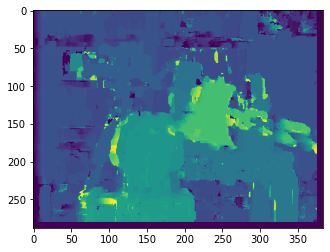

In [11]:
# Create an image to store the disparity
disparity_map = np.zeros_like(left_frame)
max_num_blocks = 5

# Parse the pixels
for i in tqdm(range(frame_shape[0] - block_size)):
    for j in range(frame_shape[1] - block_size):

        template = left_frame[i:i+block_size, j:j+block_size]

        # TODO
        
        roi = right_frame[i: i + block_size, start : end]

        res = cv2.matchTemplate(roi, template, cv2.TM_SQDIFF)

        _, _, min_loc, _ = cv2.minMaxLoc(res)

        disparity = j - (min_loc[0] + start)

        disparity_map[i, j] = disparity


plt.imshow(disparity_map)
plt.show()

## Use OpenCV BlockMatching to calculate the disparity

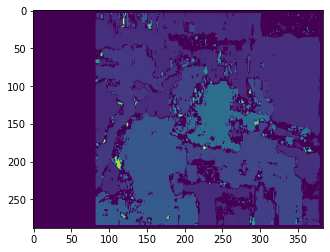

In [12]:
# we need to define a new hyper-parameter that is the number of disparities
# This number has to be a multiple of 16 and the block_size must be an odd number
block_size = 9
num_disparities = 5 * 16


stereo = cv2.StereoBM_create(numDisparities=num_disparities, blockSize=block_size)
cv_disparity = stereo.compute(left_frame, right_frame)
plt.imshow(cv_disparity)
plt.show()

## Load and visualize the ground truth disparity

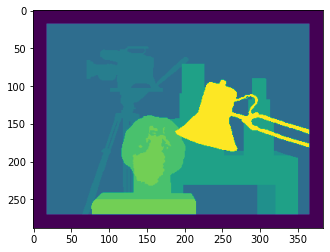

In [13]:
true_disparity = cv2.imread(disparity_path)[..., 0]
plt.imshow(true_disparity)
plt.show()

# Part C: Point Cloud reconstruction from disparity map

In [14]:
#disparity_map = true_disparity

rows, columns = disparity_map.shape[0], disparity_map.shape[1]

# finding the center of the image
u0 = columns / 2 
v0 = rows / 2

# Constant parameters, depending on the camera parameters and position
stereo_baseline = 0.2
fieldOfView = 1.2
focal_length_constant = 1.0 / (2.0 * tan(fieldOfView / 2.0))


vertices = []
colors = []

for i in range(columns):
    for j in range(rows):

        # TODO

vertices = np.stack(vertices)
colors = np.stack(colors)

#U.visualize_point_cloud(vertices, colors)

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


KeyboardInterrupt: 